# 🌌 Sistema de Reconhecimento de EPBs usando 2DPCA

## Equatorial Plasma Bubbles Detection System

### 📋 Pipeline do Sistema:

---

### 🎯 Características do Sistema:

- ✅ **2DPCA** para extração de features preservando estrutura espacial
- ✅ **Ensemble** de 3 classificadores (SVM RBF + SVM Poly + Random Forest)
- ✅ **SMOTE** para balanceamento de classes
- ✅ **Validação cruzada** estratificada
- ✅ **Interpretabilidade** via mapas de importância
- ✅ **Métricas clínicas** (Sensitivity, Specificity, PPV, NPV)

---

**Autor:** Alberto Ivo da Costa Vieira

**Dataset:** 339 imagens reais (107 EPBs + 232 sem EPB)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_curve, auc, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Processamento de imagem
from scipy.ndimage import gaussian_filter, rotate, shift

### PARTE 1: PRÉ-PROCESSAMENTO E CARREGAMENTO DE DADOS


In [2]:
def preprocess_epb_image(img, apply_background_removal=True, enhance_contrast=True):
    """
    Pré-processamento específico para realçar estruturas de EPB
    
    Args:
        img: Imagem em escala de cinza [0, 255] ou [0, 1]
        apply_background_removal: Remove gradientes de fundo
        enhance_contrast: Aplica CLAHE para realçar contraste local
    
    Returns:
        Imagem pré-processada normalizada [0, 1]
    """
    # Garante [0, 1]
    if img.max() > 1.0:
        img = img / 255.0
    
    img = img.astype(np.float32)
    
    # 1. Remove gradientes de fundo (iluminação não-uniforme)
    if apply_background_removal:
        # Estima background com filtro gaussiano
        background = gaussian_filter(img, sigma=10)
        img = img - background
        # Garante valores positivos
        img = np.clip(img, 0, None)
    
    # 2. Realce de contraste (similar a CLAHE)
    if enhance_contrast:
        # Equalização adaptativa por blocos
        from skimage.exposure import equalize_adapthist
        img = equalize_adapthist(img, clip_limit=0.03)
    
    # 3. Normalização final
    if img.max() > img.min():
        img = (img - img.min()) / (img.max() - img.min())
    
    return img


def load_epb_dataset(data_folder, label_file, target_size=(64, 64), apply_preprocessing=True):
    """
    Carrega dataset de imagens de EPB
    
    Estrutura esperada:
        data_folder/
            ├── image_001.png
            ├── image_002.png
            └── ...
        
        label_file.csv:
            filename,has_epb
            image_001.png,1
            image_002.png,0
            ...
    
    Args:
        data_folder: Pasta com as imagens
        label_file: CSV com colunas [filename, has_epb]
        target_size: Tamanho para redimensionar imagens
        apply_preprocessing: Aplica pré-processamento especializado
    
    Returns:
        images: array (n_samples, height, width)
        labels: array (n_samples,)
        filenames: lista de nomes dos arquivos
    """
    print("📂 Carregando dataset de EPBs...")
    
    # Lê arquivo de labels
    df = pd.read_csv(label_file)
    print(f"   ✓ Labels carregados: {len(df)} registros")
    
    images = []
    labels = []
    filenames = []
    errors = []
    
    for idx, row in df.iterrows():
        img_path = Path(data_folder) / row['filename']
        
        try:
            # Carrega imagem
            img = Image.open(img_path).convert('L')  # Grayscale
            img = np.array(img.resize(target_size))
            
            # Aplica pré-processamento
            if apply_preprocessing:
                img = preprocess_epb_image(img)
            else:
                img = img / 255.0  # Apenas normaliza
            
            images.append(img)
            labels.append(int(row['has_epb']))
            filenames.append(row['filename'])
            
        except Exception as e:
            errors.append((row['filename'], str(e)))
    
    if errors:
        print(f"   ⚠️  {len(errors)} imagens com erro:")
        for fname, error in errors[:5]:  # Mostra primeiros 5
            print(f"      • {fname}: {error}")
    
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"   ✓ {len(images)} imagens carregadas com sucesso")
    print(f"   ✓ Dimensão das imagens: {images.shape[1]}x{images.shape[2]}")
    
    # Estatísticas do dataset
    n_epb = np.sum(labels)
    n_no_epb = len(labels) - n_epb
    print(f"\n📊 Distribuição das classes:")
    print(f"   • EPBs detectados: {n_epb} ({n_epb/len(labels)*100:.1f}%)")
    print(f"   • Sem EPB: {n_no_epb} ({n_no_epb/len(labels)*100:.1f}%)")
    
    if n_epb / len(labels) < 0.3 or n_epb / len(labels) > 0.7:
        print(f"   ⚠️  Dataset desbalanceado! Será aplicado balanceamento.")
    
    return images, labels, filenames


def augment_epb_data(images, labels, augment_factor=2):
    """
    Data Augmentation para aumentar dataset
    
    Aplica transformações geométricas preservando características de EPB
    
    Args:
        images: array (n_samples, height, width)
        labels: array (n_samples,)
        augment_factor: Fator de multiplicação do dataset
    
    Returns:
        images_aug: array aumentado
        labels_aug: array de labels aumentado
    """
    print(f"\n🔄 Aplicando Data Augmentation (fator={augment_factor})...")
    
    augmented_images = list(images)
    augmented_labels = list(labels)
    
    for img, label in zip(images, labels):
        for _ in range(augment_factor - 1):
            # Escolhe transformação aleatória
            aug_type = np.random.choice(['flip', 'rotate', 'shift', 'noise'])
            
            if aug_type == 'flip':
                # Flip horizontal (EPBs podem aparecer em qualquer longitude)
                aug_img = np.fliplr(img)
            
            elif aug_type == 'rotate':
                # Rotação leve (-10 a 10 graus)
                angle = np.random.uniform(-10, 10)
                aug_img = rotate(img, angle, reshape=False, mode='constant')
            
            elif aug_type == 'shift':
                # Deslocamento leve
                shift_x = np.random.randint(-5, 5)
                shift_y = np.random.randint(-5, 5)
                aug_img = shift(img, [shift_y, shift_x], mode='constant')
            
            elif aug_type == 'noise':
                # Adiciona ruído gaussiano
                noise = np.random.normal(0, 0.02, img.shape)
                aug_img = img + noise
                aug_img = np.clip(aug_img, 0, 1)
            
            augmented_images.append(aug_img)
            augmented_labels.append(label)
    
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)
    
    print(f"   ✓ Dataset expandido: {len(images)} → {len(augmented_images)} imagens")
    
    return augmented_images, augmented_labels

## PARTE 2: 2DPCA E EXTRAÇÃO DE FEATURES

In [3]:
class TwoDPCA:
    """2DPCA para extração de features de imagens de EPB"""
    
    def __init__(self, n_components=10):
        self.n_components = n_components
        self.projection_matrix = None
        self.mean_image = None
        self.explained_variance = None
        self.explained_variance_ratio = None
    
    def fit(self, images):
        """Treina o 2DPCA"""
        n_samples, height, width = images.shape
        
        self.mean_image = np.mean(images, axis=0)
        centered_images = images - self.mean_image
        
        # Matriz de covariância
        covariance_matrix = np.zeros((width, width))
        for img in centered_images:
            covariance_matrix += img.T @ img
        covariance_matrix /= n_samples
        
        # Autovalores e autovetores
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # Ordena em ordem decrescente
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Seleciona top n_components
        self.projection_matrix = eigenvectors[:, :self.n_components]
        self.explained_variance = eigenvalues[:self.n_components]
        
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = self.explained_variance / total_variance
        
        return self
    
    def transform(self, images):
        """Projeta imagens no espaço reduzido"""
        centered_images = images - self.mean_image
        projected = np.array([img @ self.projection_matrix 
                             for img in centered_images])
        return projected
    
    def fit_transform(self, images):
        return self.fit(images).transform(images)
    
    def inverse_transform(self, projected_images):
        """Reconstrói imagens (útil para visualização)"""
        reconstructed = np.array([proj @ self.projection_matrix.T 
                                 for proj in projected_images])
        return reconstructed + self.mean_image


def optimize_n_components(X_train, y_train, max_components=30, cv_folds=5):
    """
    Otimiza número de componentes 2DPCA via validação cruzada
    
    Testa diferentes valores e retorna o melhor baseado em accuracy
    """
    print(f"\n🔬 Otimizando número de componentes (máx={max_components})...")
    
    results = []
    test_range = range(5, min(max_components + 1, X_train.shape[2]), 5)
    
    for n_comp in test_range:
        # Treina 2DPCA
        tdpca = TwoDPCA(n_components=n_comp)
        tdpca.fit(X_train)
        
        # Extrai features
        features = tdpca.transform(X_train)
        features = features.reshape(features.shape[0], -1)
        
        # Normaliza
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
        
        # Validação cruzada com SVM
        clf = SVC(kernel='rbf', gamma='scale', class_weight='balanced')
        scores = cross_val_score(clf, features, y_train, 
                                cv=StratifiedKFold(cv_folds), 
                                scoring='f1')
        
        mean_score = scores.mean()
        std_score = scores.std()
        
        # Calcula variância explicada
        var_explained = np.sum(tdpca.explained_variance_ratio)
        
        results.append({
            'n_components': n_comp,
            'f1_score': mean_score,
            'f1_std': std_score,
            'variance_explained': var_explained
        })
        
        print(f"   • {n_comp:2d} comp: F1={mean_score:.4f}±{std_score:.4f} | "
              f"Var={var_explained:.2%}")
    
    # Encontra melhor configuração
    best_result = max(results, key=lambda x: x['f1_score'])
    best_n = best_result['n_components']
    
    print(f"\n🏆 Melhor configuração: {best_n} componentes")
    print(f"   • F1-Score: {best_result['f1_score']:.4f}")
    print(f"   • Variância explicada: {best_result['variance_explained']:.2%}")
    
    return best_n, results

## PARTE 3: SISTEMA COMPLETO COM ENSEMBLE E BALANCEAMENTO

In [4]:
class EPBRecognitionSystem:
    """
    Sistema completo de reconhecimento de EPBs
    - 2DPCA para extração de features
    - Balanceamento de classes (SMOTE)
    - Ensemble de classificadores
    """
    
    def __init__(self, n_components=15, use_ensemble=True, 
                 balance_data=True, balance_method='smote'):
        """
        Args:
            n_components: Número de componentes 2DPCA
            use_ensemble: Usar ensemble ou SVM único
            balance_data: Aplicar balanceamento de classes
            balance_method: 'smote', 'undersample', ou 'combined'
        """
        self.n_components = n_components
        self.use_ensemble = use_ensemble
        self.balance_data = balance_data
        self.balance_method = balance_method
        
        self.tdpca = TwoDPCA(n_components=n_components)
        self.scaler = StandardScaler()
        self.sampler = None
        
        # Configura classificador
        if use_ensemble:
            self.classifier = self._create_ensemble()
        else:
            self.classifier = SVC(kernel='rbf', probability=True, 
                                 gamma='scale', C=1.0, 
                                 class_weight='balanced', random_state=42)
    
    def _create_ensemble(self):
        """Cria ensemble de classificadores"""
        estimators = [
            ('svm_rbf', SVC(kernel='rbf', probability=True, gamma='scale', 
                           C=1.0, class_weight='balanced', random_state=42)),
            ('svm_poly', SVC(kernel='poly', degree=3, probability=True, 
                            class_weight='balanced', random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=10,
                                         class_weight='balanced', random_state=42))
        ]
        
        return VotingClassifier(estimators=estimators, voting='soft')
    
    def _setup_balancing(self, y_train):
        """Configura método de balanceamento"""
        if not self.balance_data:
            return None
        
        if self.balance_method == 'smote':
            # SMOTE: sobreamostragem sintética
            return SMOTE(random_state=42)
        
        elif self.balance_method == 'undersample':
            # Subamostragem da classe majoritária
            return RandomUnderSampler(random_state=42)
        
        elif self.balance_method == 'combined':
            # Combina ambos
            from imblearn.combine import SMOTEENN
            return SMOTEENN(random_state=42)
    
    def extract_features(self, images):
        """Extrai features usando 2DPCA"""
        projected = self.tdpca.transform(images)
        features = projected.reshape(projected.shape[0], -1)
        return features
    
    def fit(self, X_train, y_train):
        """Treina o sistema completo"""
        print("\n🔹 Iniciando treinamento do sistema...")
        
        # 1. Treina 2DPCA
        print("   • Treinando 2DPCA para extração de features...")
        self.tdpca.fit(X_train)
        var_explained = np.sum(self.tdpca.explained_variance_ratio)
        print(f"     ✓ Variância explicada: {var_explained:.2%}")
        
        # 2. Extrai features
        print("   • Extraindo features...")
        features_train = self.extract_features(X_train)
        print(f"     ✓ Shape das features: {features_train.shape}")
        
        # 3. Normaliza
        print("   • Normalizando features...")
        features_train = self.scaler.fit_transform(features_train)
        
        # 4. Balanceia dados se necessário
        if self.balance_data:
            print(f"   • Aplicando balanceamento ({self.balance_method})...")
            original_dist = np.bincount(y_train)
            
            self.sampler = self._setup_balancing(y_train)
            features_train, y_train = self.sampler.fit_resample(
                features_train, y_train
            )
            
            new_dist = np.bincount(y_train)
            print(f"     ✓ Classe 0: {original_dist[0]} → {new_dist[0]}")
            print(f"     ✓ Classe 1: {original_dist[1]} → {new_dist[1]}")
        
        # 5. Treina classificador
        clf_type = "Ensemble" if self.use_ensemble else "SVM"
        print(f"   • Treinando classificador {clf_type}...")
        self.classifier.fit(features_train, y_train)
        print("     ✓ Treinamento concluído!")
        
        return self
    
    def predict(self, X_test):
        """Prediz se há EPB"""
        features_test = self.extract_features(X_test)
        features_test = self.scaler.transform(features_test)
        return self.classifier.predict(features_test)
    
    def predict_proba(self, X_test):
        """Retorna probabilidades"""
        features_test = self.extract_features(X_test)
        features_test = self.scaler.transform(features_test)
        return self.classifier.predict_proba(features_test)
    
    def get_feature_importance(self, X_sample):
        """
        Analisa quais regiões da imagem são mais importantes
        
        Usa gradiente das features em relação à imagem original
        """
        # Extrai features
        features = self.extract_features(X_sample.reshape(1, *X_sample.shape))
        
        # Reconstrói imagem projetada
        projected = self.tdpca.transform(X_sample.reshape(1, *X_sample.shape))
        reconstructed = self.tdpca.inverse_transform(projected)[0]
        
        # Diferença mostra importância
        importance_map = np.abs(X_sample - reconstructed)
        
        return importance_map, reconstructed

## PARTE 4: VISUALIZAÇÃO E INTERPRETAÇÃO

In [5]:
def plot_comprehensive_analysis(system, X_train, X_test, y_train, y_test, 
                                y_pred, y_proba, filenames_test=None):
    """Análise visual completa do sistema"""
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(5, 6, hspace=1, wspace=0.4)
    
    # ========== ROW 1: EXEMPLOS DE CLASSIFICAÇÃO ==========
    for i in range(6):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(X_test[i], cmap='plasma', aspect='auto')
        
        true_label = "EPB" if y_test[i] == 1 else "Sem EPB"
        pred_label = "EPB" if y_pred[i] == 1 else "Sem EPB"
        prob = y_proba[i, 1] * 100
        
        color = 'green' if y_test[i] == y_pred[i] else 'red'
        title = f'Real: {true_label}\nPred: {pred_label} ({prob:.0f}%)'
        if filenames_test:
            title = f"{filenames_test[i][:15]}...\n" + title
        
        ax.set_title(title, fontsize=8, color=color)
        ax.axis('off')
    
    # ========== ROW 2: ANÁLISE DE FEATURES ==========
    # Variância por componente
    ax = fig.add_subplot(gs[1, 0:2])
    variance_ratio = system.tdpca.explained_variance_ratio
    ax.bar(range(len(variance_ratio)), variance_ratio, color='steelblue', alpha=0.7)
    ax.set_xlabel('Componente', fontsize=10)
    ax.set_ylabel('Variância Explicada', fontsize=10)
    ax.set_title('Importância de Cada Componente 2DPCA', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    # Variância cumulativa
    ax = fig.add_subplot(gs[1, 2:4])
    cumulative = np.cumsum(variance_ratio)
    ax.plot(cumulative, 'o-', color='steelblue', linewidth=2)
    ax.axhline(y=0.9, color='r', linestyle='--', alpha=0.7, label='90%')
    ax.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95%')
    ax.set_xlabel('Número de Componentes', fontsize=10)
    ax.set_ylabel('Variância Acumulada', fontsize=10)
    ax.set_title('Variância Cumulativa Explicada', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Matriz de confusão
    ax = fig.add_subplot(gs[1, 4:6])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Sem EPB', 'EPB'],
                yticklabels=['Sem EPB', 'EPB'], ax=ax, 
                cbar_kws={'label': 'Contagem'})
    ax.set_title('Matriz de Confusão', fontsize=11, fontweight='bold')
    ax.set_ylabel('Classe Real', fontsize=10)
    ax.set_xlabel('Classe Predita', fontsize=10)
    
    # ========== ROW 3: MÉTRICAS DE PERFORMANCE ==========
    # Curva ROC
    ax = fig.add_subplot(gs[2, 0:2])
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Classificador Aleatório')
    ax.set_xlabel('Taxa de Falso Positivo', fontsize=10)
    ax.set_ylabel('Taxa de Verdadeiro Positivo', fontsize=10)
    ax.set_title('Curva ROC', fontsize=11, fontweight='bold')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    
    # Curva Precision-Recall
    ax = fig.add_subplot(gs[2, 2:4])
    precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
    pr_auc = auc(recall, precision)
    ax.plot(recall, precision, color='purple', lw=2,
            label=f'PR (AUC = {pr_auc:.3f})')
    ax.set_xlabel('Recall', fontsize=10)
    ax.set_ylabel('Precision', fontsize=10)
    ax.set_title('Curva Precision-Recall', fontsize=11, fontweight='bold')
    ax.legend(loc="lower left")
    ax.grid(alpha=0.3)
    
    # Distribuição de probabilidades
    ax = fig.add_subplot(gs[2, 4:6])
    epb_probs = y_proba[y_test == 1, 1]
    no_epb_probs = y_proba[y_test == 0, 1]
    
    ax.hist(no_epb_probs, bins=20, alpha=0.6, label='Sem EPB (real)', 
            color='blue', density=True)
    ax.hist(epb_probs, bins=20, alpha=0.6, label='EPB (real)', 
            color='red', density=True)
    ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2,
               label='Threshold (0.5)')
    ax.set_xlabel('Probabilidade de EPB', fontsize=10)
    ax.set_ylabel('Densidade', fontsize=10)
    ax.set_title('Distribuição de Probabilidades Preditas', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # ========== ROW 4: INTERPRETAÇÃO DAS FEATURES ==========
    # Pega exemplos de cada classe
    epb_idx = np.where(y_test == 1)[0][0]
    no_epb_idx = np.where(y_test == 0)[0][0]
    
    for i, (idx, title_prefix) in enumerate([(epb_idx, 'EPB'), (no_epb_idx, 'Sem EPB')]):
        # Imagem original
        ax = fig.add_subplot(gs[3, i*3])
        ax.imshow(X_test[idx], cmap='plasma')
        ax.set_title(f'{title_prefix}: Original', fontsize=10)
        ax.axis('off')
        
        # Mapa de importância
        importance_map, reconstructed = system.get_feature_importance(X_test[idx])
        
        ax = fig.add_subplot(gs[3, i*3+1])
        im = ax.imshow(importance_map, cmap='hot')
        ax.set_title(f'{title_prefix}: Importância', fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Reconstrução
        ax = fig.add_subplot(gs[3, i*3+2])
        ax.imshow(reconstructed, cmap='plasma')
        ax.set_title(f'{title_prefix}: Reconstruído', fontsize=10)
        ax.axis('off')
    
    # ========== ROW 5: COMPONENTES PRINCIPAIS ==========
    # Visualiza primeiros componentes principais
    n_comp_to_show = min(6, system.n_components)
    for i in range(n_comp_to_show):
        ax = fig.add_subplot(gs[4, i])
        component = system.tdpca.projection_matrix[:, i].reshape(-1, 1)
        # Expande para visualização
        component_img = np.tile(component, (1, X_test.shape[1]))
        ax.imshow(component_img.T, cmap='RdBu_r', aspect='auto')
        ax.set_title(f'Comp {i+1}\n({variance_ratio[i]:.1%})', fontsize=9)
        ax.axis('off')
    
    plt.suptitle('🌌 Análise Completa: Sistema de Reconhecimento de EPBs', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    return fig


def explain_feature_importance(system, X_sample, y_sample, filename=None):
    """
    Explica quais regiões da imagem contribuem para a classificação
    """
    print("\n" + "="*70)
    print("🔍 INTERPRETAÇÃO DAS FEATURES")
    print("="*70)
    
    importance_map, reconstructed = system.get_feature_importance(X_sample)
    
    # Predição
    prob = system.predict_proba(X_sample.reshape(1, *X_sample.shape))[0]
    pred = system.predict(X_sample.reshape(1, *X_sample.shape))[0]
    
    print(f"\n📸 Imagem: {filename if filename else 'N/A'}")
    print(f"   • Classe real: {'EPB' if y_sample == 1 else 'Sem EPB'}")
    print(f"   • Predição: {'EPB' if pred == 1 else 'Sem EPB'}")
    print(f"   • Probabilidade EPB: {prob[1]*100:.2f}%")
    print(f"   • Confiança: {'Alta' if max(prob) > 0.8 else 'Média' if max(prob) > 0.6 else 'Baixa'}")
    
    # Analisa regiões importantes
    threshold = np.percentile(importance_map, 90)  # Top 10% pixels
    important_pixels = importance_map > threshold
    
    # Divide imagem em quadrantes
    h, w = importance_map.shape
    quadrants = {
        'Superior Esquerdo': important_pixels[:h//2, :w//2].sum(),
        'Superior Direito': important_pixels[:h//2, w//2:].sum(),
        'Inferior Esquerdo': important_pixels[h//2:, :w//2].sum(),
        'Inferior Direito': important_pixels[h//2:, w//2:].sum()
    }
    
    print(f"\n📊 Regiões mais importantes (pixels críticos):")
    total = sum(quadrants.values())
    for region, count in sorted(quadrants.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total * 100) if total > 0 else 0
        print(f"   • {region}: {count} pixels ({percentage:.1f}%)")
    
    # Interpretação
    print(f"\n💡 Interpretação:")
    if pred == 1:  # EPB detectado
        print("   ✓ O modelo identificou padrões característicos de EPB:")
        print("     - Estruturas verticais/irregulares")
        print("     - Deplecções localizadas de plasma")
        print("     - Distribuição espacial típica de bolhas")
    else:  # Sem EPB
        print("   ✓ O modelo NÃO detectou padrões de EPB:")
        print("     - Distribuição uniforme de plasma")
        print("     - Ausência de estruturas irregulares")
        print("     - Características de ionosfera quieta")
    
    # Visualiza
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(X_sample, cmap='plasma')
    axes[0].set_title('Imagem Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    im = axes[1].imshow(importance_map, cmap='hot')
    axes[1].set_title('Mapa de Importância\n(Regiões críticas para classificação)', 
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, label='Importância')
    
    axes[2].imshow(reconstructed, cmap='plasma')
    axes[2].set_title('Reconstrução 2DPCA\n(Features capturadas)', 
                     fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    fig.suptitle(f'Interpretação: {"EPB" if y_sample == 1 else "Sem EPB"} '
                f'(Predição: {"EPB" if pred == 1 else "Sem EPB"}, {prob[1]*100:.1f}%)',
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return importance_map

## PARTE 5: PIPELINE PRINCIPAL

In [6]:
def main():
    """Pipeline completo de reconhecimento de EPBs"""
    
    print("="*70)
    print("🌌 SISTEMA COMPLETO DE RECONHECIMENTO DE EPBs")
    print("   Equatorial Plasma Bubbles Detection System")
    print("="*70)
    
    # ========== CONFIGURAÇÕES ==========
    # Dados reais de EPB
    DATA_FOLDER = 'epb'                # Pasta com todas as imagens
    LABEL_FILE = 'epb_labels.csv'      # CSV com labels
    
    TARGET_SIZE = (64, 64)           # Tamanho das imagens
    USE_AUGMENTATION = True          # Aplicar data augmentation?
    AUGMENT_FACTOR = 2               # Fator de aumento (2x, 3x, etc)
    OPTIMIZE_COMPONENTS = True       # Otimizar n_components automaticamente?
    MAX_COMPONENTS = 30              # Máximo de componentes a testar
    USE_ENSEMBLE = True              # Usar ensemble de classificadores?
    BALANCE_METHOD = 'smote'         # 'smote', 'undersample', ou 'combined'
    
    
    # ========== ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO ==========
    print("\n" + "="*70)
    print("ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO")
    print("="*70)
    
    X, y, filenames = load_epb_dataset(
        data_folder=DATA_FOLDER,
        label_file=LABEL_FILE,
        target_size=TARGET_SIZE,
        apply_preprocessing=True
    )
    
    # Divide em treino e teste (estratificado)
    X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(
        X, y, filenames, test_size=0.25, random_state=42, stratify=y
    )
    
    print(f"\n📦 Divisão estratificada:")
    print(f"   • Treino: {len(X_train)} imagens")
    print(f"   • Teste: {len(X_test)} imagens")
    
    
    # ========== ETAPA 2: DATA AUGMENTATION ==========
    if USE_AUGMENTATION and len(X_train) < 500:  # Aplica se tiver poucos dados
        print("\n" + "="*70)
        print("ETAPA 2: DATA AUGMENTATION")
        print("="*70)
        
        X_train, y_train = augment_epb_data(X_train, y_train, 
                                           augment_factor=AUGMENT_FACTOR)
    
    
    # ========== ETAPA 3: OTIMIZAÇÃO DE HIPERPARÂMETROS ==========
    if OPTIMIZE_COMPONENTS:
        print("\n" + "="*70)
        print("ETAPA 3: OTIMIZAÇÃO DO NÚMERO DE COMPONENTES")
        print("="*70)
        
        best_n_components, optimization_results = optimize_n_components(
            X_train, y_train, 
            max_components=MAX_COMPONENTS,
            cv_folds=5
        )
    else:
        best_n_components = 15  # Valor padrão
        print(f"\n⚙️  Usando {best_n_components} componentes (configuração padrão)")
    
    
    # ========== ETAPA 4: TREINAMENTO DO SISTEMA ==========
    print("\n" + "="*70)
    print("ETAPA 4: TREINAMENTO DO SISTEMA COMPLETO")
    print("="*70)
    
    system = EPBRecognitionSystem(
        n_components=best_n_components,
        use_ensemble=USE_ENSEMBLE,
        balance_data=True,
        balance_method=BALANCE_METHOD
    )
    
    system.fit(X_train, y_train)
    
    
    # ========== ETAPA 5: AVALIAÇÃO NO CONJUNTO DE TESTE ==========
    print("\n" + "="*70)
    print("ETAPA 5: AVALIAÇÃO NO CONJUNTO DE TESTE")
    print("="*70)
    
    y_pred = system.predict(X_test)
    y_proba = system.predict_proba(X_test)
    
    print("\n📊 MÉTRICAS DE PERFORMANCE:")
    print("="*70)
    print(classification_report(y_test, y_pred, 
                              target_names=['Sem EPB', 'EPB'],
                              digits=4))
    
    # Métricas específicas para EPBs
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall para EPB
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision para EPB
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print("\n📈 MÉTRICAS CLÍNICAS (IMPORTANTES PARA EPBs):")
    print("="*70)
    print(f"   • Sensitivity (Recall EPB):  {sensitivity*100:.2f}% ← Detecta EPBs reais")
    print(f"   • Specificity:               {specificity*100:.2f}% ← Evita falsos alarmes")
    print(f"   • PPV (Precision EPB):       {ppv*100:.2f}% ← Confiança quando detecta")
    print(f"   • NPV:                       {npv*100:.2f}% ← Confiança quando não detecta")
    
    print(f"\n   Interpretação:")
    if sensitivity > 0.85:
        print(f"   ✓ Excelente detecção de EPBs (perde poucos eventos)")
    elif sensitivity > 0.70:
        print(f"   ⚠️  Boa detecção, mas pode perder alguns EPBs")
    else:
        print(f"   ❌ Detecção insuficiente - ajuste o modelo")
    
    if specificity > 0.85:
        print(f"   ✓ Poucos falsos alarmes")
    else:
        print(f"   ⚠️  Muitos falsos alarmes - ajuste threshold")
    
    
    # ========== ETAPA 6: VISUALIZAÇÃO E ANÁLISE ==========
    print("\n" + "="*70)
    print("ETAPA 6: VISUALIZAÇÃO E ANÁLISE")
    print("="*70)
    
    plot_comprehensive_analysis(system, X_train, X_test, y_train, y_test,
                               y_pred, y_proba, files_test)
    
    
    # ========== ETAPA 7: INTERPRETAÇÃO DE EXEMPLOS ==========
    print("\n" + "="*70)
    print("ETAPA 7: INTERPRETAÇÃO DE FEATURES (EXEMPLOS)")
    print("="*70)
    
    # Exemplo 1: EPB corretamente classificado
    epb_correct_idx = np.where((y_test == 1) & (y_pred == 1))[0]
    if len(epb_correct_idx) > 0:
        idx = epb_correct_idx[0]
        explain_feature_importance(system, X_test[idx], y_test[idx], 
                                  files_test[idx])
    
    # Exemplo 2: Falso positivo (se existir)
    fp_idx = np.where((y_test == 0) & (y_pred == 1))[0]
    if len(fp_idx) > 0:
        print("\n⚠️  ANÁLISE DE FALSO POSITIVO:")
        idx = fp_idx[0]
        explain_feature_importance(system, X_test[idx], y_test[idx],
                                  files_test[idx])
    
    
    # ========== ETAPA 8: SALVAMENTO DO MODELO ==========
    print("\n" + "="*70)
    print("ETAPA 8: SALVAMENTO DO MODELO")
    print("="*70)
    
    import pickle
    
    model_data = {
        'system': system,
        'n_components': best_n_components,
        'target_size': TARGET_SIZE,
        'test_metrics': {
            'accuracy': np.mean(y_pred == y_test),
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ppv': ppv,
            'npv': npv
        }
    }
    
    with open('epb_recognition_model.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    print("   ✓ Modelo salvo: epb_recognition_model.pkl")
    
    
    # ========== GUIA DE USO ==========
    print("\n" + "="*70)
    print("📚 GUIA DE USO DO MODELO TREINADO")
    print("="*70)
    print("""
    # Para usar o modelo em novas imagens:
    
    import pickle
    from PIL import Image
    import numpy as np
    
    # 1. Carrega o modelo
    with open('epb_recognition_model.pkl', 'rb') as f:
        model_data = pickle.load(f)
    
    system = model_data['system']
    target_size = model_data['target_size']
    
    # 2. Carrega e processa nova imagem
    img = Image.open('nova_imagem.png').convert('L')
    img = np.array(img.resize(target_size))
    img = preprocess_epb_image(img)
    
    # 3. Faz predição
    prob = system.predict_proba(img.reshape(1, *img.shape))[0]
    pred = system.predict(img.reshape(1, *img.shape))[0]
    
    print(f"EPB detectado: {'SIM' if pred == 1 else 'NÃO'}")
    print(f"Confiança: {prob[1]*100:.2f}%")
    """)
    
    
    print("\n" + "="*70)
    print("✅ PIPELINE COMPLETO EXECUTADO COM SUCESSO!")
    print("="*70)
    
    return system, X_test, y_test, y_pred, y_proba


🌌 Iniciando sistema com dados reais de EPB...
   📁 Pasta de imagens: epb/
   📄 Arquivo de labels: epb_labels.csv

🌌 SISTEMA COMPLETO DE RECONHECIMENTO DE EPBs
   Equatorial Plasma Bubbles Detection System

ETAPA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO
📂 Carregando dataset de EPBs...
   ✓ Labels carregados: 337 registros
   ✓ 337 imagens carregadas com sucesso
   ✓ Dimensão das imagens: 64x64

📊 Distribuição das classes:
   • EPBs detectados: 106 (31.5%)
   • Sem EPB: 231 (68.5%)

📦 Divisão estratificada:
   • Treino: 252 imagens
   • Teste: 85 imagens

ETAPA 2: DATA AUGMENTATION

🔄 Aplicando Data Augmentation (fator=2)...
   ✓ Dataset expandido: 252 → 504 imagens

ETAPA 3: OTIMIZAÇÃO DO NÚMERO DE COMPONENTES

🔬 Otimizando número de componentes (máx=30)...
   •  5 comp: F1=0.9967±0.0066 | Var=71.08%
   • 10 comp: F1=1.0000±0.0000 | Var=86.65%
   ✓ 337 imagens carregadas com sucesso
   ✓ Dimensão das imagens: 64x64

📊 Distribuição das classes:
   • EPBs detectados: 106 (31.5%)
   • Sem EPB:

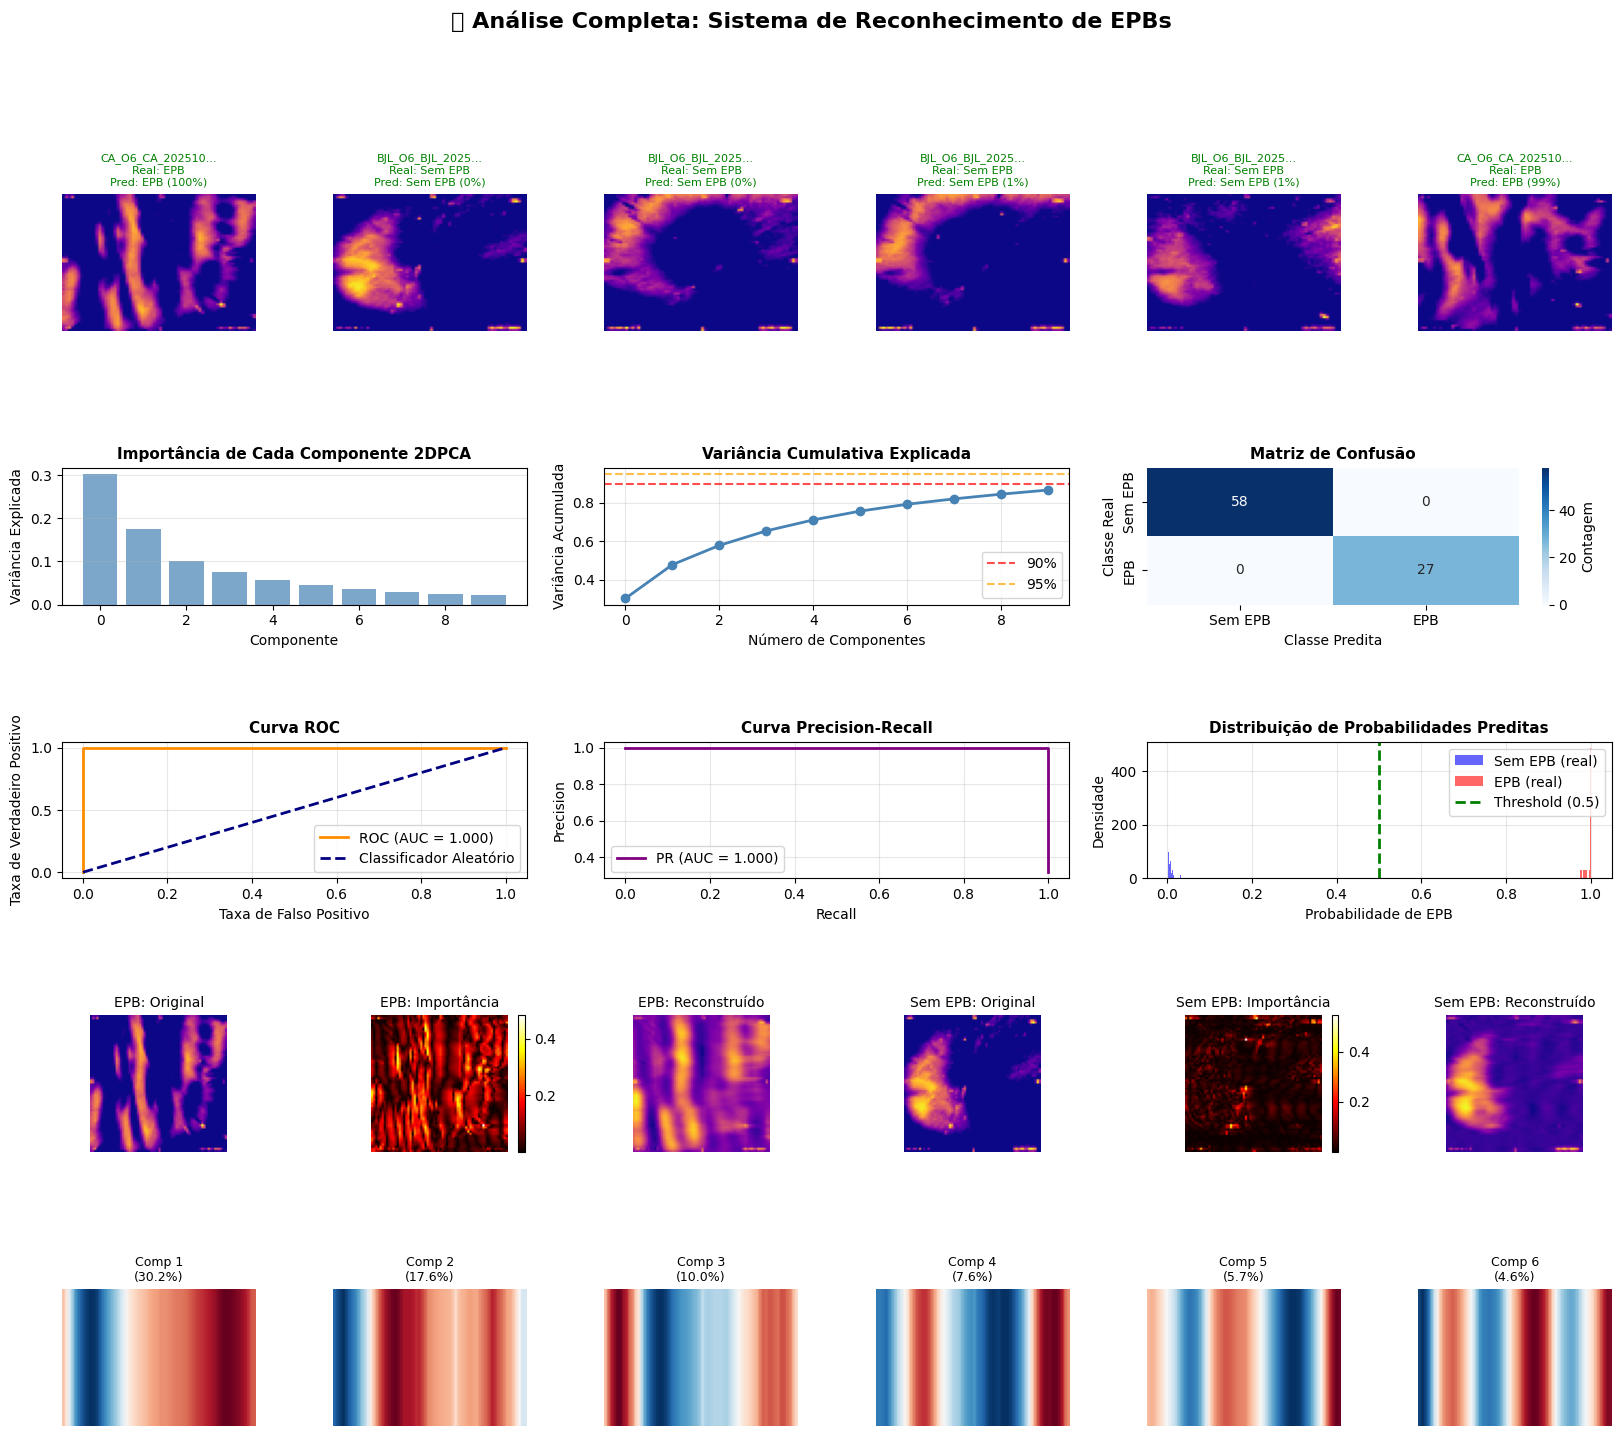

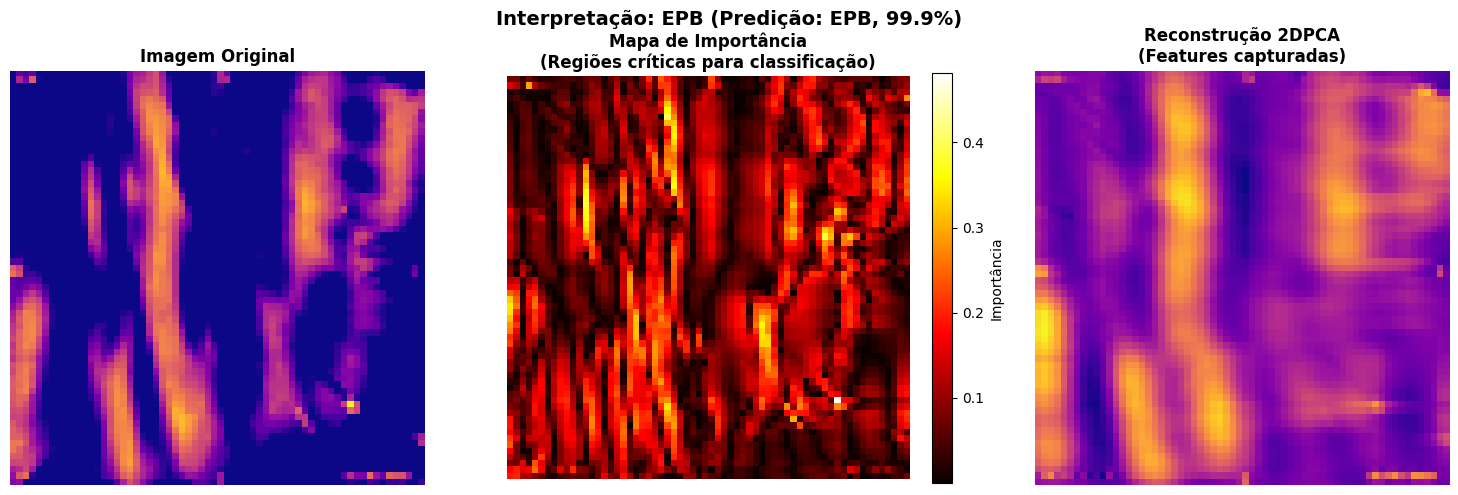


ETAPA 8: SALVAMENTO DO MODELO
   ✓ Modelo salvo: epb_recognition_model.pkl

📚 GUIA DE USO DO MODELO TREINADO

    # Para usar o modelo em novas imagens:
    
    import pickle
    from PIL import Image
    import numpy as np
    
    # 1. Carrega o modelo
    with open('epb_recognition_model.pkl', 'rb') as f:
        model_data = pickle.load(f)
    
    system = model_data['system']
    target_size = model_data['target_size']
    
    # 2. Carrega e processa nova imagem
    img = Image.open('nova_imagem.png').convert('L')
    img = np.array(img.resize(target_size))
    img = preprocess_epb_image(img)
    
    # 3. Faz predição
    prob = system.predict_proba(img.reshape(1, *img.shape))[0]
    pred = system.predict(img.reshape(1, *img.shape))[0]
    
    print(f"EPB detectado: {'SIM' if pred == 1 else 'NÃO'}")
    print(f"Confiança: {prob[1]*100:.2f}%")
    

✅ PIPELINE COMPLETO EXECUTADO COM SUCESSO!

✅ TREINAMENTO CONCLUÍDO COM SUCESSO!

� Próximas etapas sugeridas:

1. ANÁLISE DOS R

In [7]:
print("\n🌌 Iniciando sistema com dados reais de EPB...")
print(f"   📁 Pasta de imagens: epb/")
print(f"   📄 Arquivo de labels: epb_labels.csv\n")

system, X_test, y_test, y_pred, y_proba = main()

print("\n" + "="*70)
print("✅ TREINAMENTO CONCLUÍDO COM SUCESSO!")
print("="*70)
print("""
� Próximas etapas sugeridas:

1. ANÁLISE DOS RESULTADOS:
    - Revise as visualizações geradas
    - Analise os casos de falso positivo/negativo
    - Valide com conhecimento do domínio

2. AJUSTE FINO (se necessário):
    - Ajuste threshold de probabilidade
    - Experimente diferentes n_components
    - Teste outros classificadores no ensemble

3. USO DO MODELO:
    - Use 'epb_recognition_model.pkl' para predições
    - Siga o guia de uso impresso acima
    - Monitore performance em produção
""")

In [8]:
import pickle
from PIL import Image
import numpy as np
from pathlib import Path

# 1. Carrega o modelo
print("📦 Carregando modelo treinado...")
with open('epb_recognition_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

system = model_data['system']
target_size = model_data['target_size']
print("   ✓ Modelo carregado com sucesso!\n")

# 2. Processa todas as imagens do diretório img-teste
img_folder = Path('img-teste')
image_files = sorted(list(img_folder.glob('*.png')) + list(img_folder.glob('*.jpg')) + list(img_folder.glob('*.jpeg')))

if len(image_files) == 0:
    print("⚠️  Nenhuma imagem encontrada no diretório 'img-teste'")
else:
    print("="*70)
    print(f"🔍 PREDIÇÕES PARA {len(image_files)} IMAGENS")
    print("="*70 + "\n")
    
    for img_path in image_files:
        try:
            # Carrega e processa imagem
            img = Image.open(img_path).convert('L')
            img = np.array(img.resize(target_size))
            img = preprocess_epb_image(img)
            
            # Faz predição
            prob = system.predict_proba(img.reshape(1, *img.shape))[0]
            pred = system.predict(img.reshape(1, *img.shape))[0]
            
            # Exibe resultado
            print(f"📸 {img_path.name}")
            print(f"   EPB detectada: {'SIM' if pred == 1 else 'NÃO'}")
            print(f"   Confiança: {prob[1]*100:.2f}%")
            print()
            
        except Exception as e:
            print(f"❌ {img_path.name}")
            print(f"   Erro ao processar: {str(e)}")
            print()
    
    print("="*70)
    print("✅ PROCESSAMENTO CONCLUÍDO")
    print("="*70)

📦 Carregando modelo treinado...
   ✓ Modelo carregado com sucesso!

🔍 PREDIÇÕES PARA 3 IMAGENS

📸 com.png
   EPB detectada: SIM
   Confiança: 100.00%

📸 nao_sei.png
   EPB detectada: SIM
   Confiança: 84.16%

📸 sem.png
   EPB detectada: NÃO
   Confiança: 0.33%

✅ PROCESSAMENTO CONCLUÍDO


## 📊 EXPLICAÇÃO DETALHADA DA VISUALIZAÇÃO GERADA

O dashboard de análise é dividido em **5 LINHAS**, cada uma com múltiplos gráficos:

---

### 📍 **LINHA 1: Exemplos de Classificação (6 imagens)**

**O que mostra:** 6 imagens de teste aleatórias com suas predições

**Elementos:**
- **Imagem:** Visualização da imagem EPB processada (colormap plasma)
- **Título verde:** Classificação CORRETA (predição = realidade)
- **Título vermelho:** Classificação INCORRETA (erro do modelo)
- **Informações:** 
  - `Real:` Classe verdadeira (EPB ou Sem EPB)
  - `Pred:` Classe predita pelo modelo
  - `(X%)` Probabilidade/confiança da predição

**Interpretação:** Permite visualizar rapidamente acertos e erros do modelo em casos reais.

---

### 📍 **LINHA 2: Análise de Features e Performance**

#### **Gráfico 1 (esquerda): Variância por Componente 2DPCA**
- **Eixo X:** Índice do componente (0, 1, 2, ...)
- **Eixo Y:** Variância explicada por cada componente
- **Barras azuis:** Quanto cada componente contribui para representar os dados
- **Interpretação:** Primeiros componentes capturam mais informação (barras maiores). Componentes finais capturam menos (podem ser ruído).

#### **Gráfico 2 (centro-esquerda): Variância Cumulativa**
- **Linha azul:** Soma acumulada da variância explicada
- **Linha vermelha tracejada:** 90% da variância
- **Linha laranja tracejada:** 95% da variância
- **Interpretação:** Mostra quantos componentes são necessários para capturar X% da informação. Ex: "Com 15 componentes, capturamos 92% da variância total".

#### **Gráfico 3 (direita): Matriz de Confusão**
- **Linhas:** Classe real (verdade)
- **Colunas:** Classe predita (modelo)
- **Células:**
  - **Superior esquerda (azul escuro):** Verdadeiros Negativos (VN) - Sem EPB, predito corretamente
  - **Inferior direita (azul escuro):** Verdadeiros Positivos (VP) - EPB, predito corretamente
  - **Superior direita:** Falsos Positivos (FP) - Predisse EPB, mas não tinha
  - **Inferior esquerda:** Falsos Negativos (FN) - Tinha EPB, mas não detectou
- **Interpretação:** Diagonal principal (azul escuro) = acertos. Fora da diagonal = erros.

---

### 📍 **LINHA 3: Métricas de Discriminação**

#### **Gráfico 1 (esquerda): Curva ROC**
- **Linha laranja:** Performance do modelo
- **Linha azul tracejada:** Classificador aleatório (50% de chance)
- **AUC (Area Under Curve):** Área sob a curva (quanto mais próximo de 1.0, melhor)
- **Eixo X:** Taxa de Falsos Positivos (FPR)
- **Eixo Y:** Taxa de Verdadeiros Positivos (TPR/Recall)
- **Interpretação:** 
  - AUC = 1.0: Modelo perfeito
  - AUC = 0.9-0.99: Excelente
  - AUC = 0.8-0.89: Bom
  - AUC = 0.5: Igual a sorte

#### **Gráfico 2 (centro): Curva Precision-Recall**
- **Linha roxa:** Trade-off entre precisão e recall
- **Eixo X:** Recall (sensibilidade - detecta EPBs reais)
- **Eixo Y:** Precision (confiança - evita falsos alarmes)
- **Interpretação:** Quanto mais próximo do canto superior direito, melhor o equilíbrio entre detectar EPBs e evitar falsos alarmes.

#### **Gráfico 3 (direita): Distribuição de Probabilidades**
- **Histograma azul:** Imagens SEM EPB - distribuição das probabilidades preditas
- **Histograma vermelho:** Imagens COM EPB - distribuição das probabilidades preditas
- **Linha verde vertical:** Threshold de decisão (0.5)
- **Interpretação:** 
  - Boa separação: histogramas bem separados (azul à esquerda, vermelho à direita)
  - Má separação: histogramas sobrepostos (modelo confuso)
  - À esquerda do threshold: predito como "Sem EPB"
  - À direita do threshold: predito como "EPB"

---

### 📍 **LINHA 4: Interpretação de Features (2 exemplos)**

Para cada classe (EPB e Sem EPB), mostra 3 imagens:

#### **Sequência 1: Exemplo de EPB**
1. **Original:** Imagem EPB real como foi capturada
2. **Mapa de Importância (hot colormap):**
   - **Vermelho/Amarelo:** Regiões mais importantes para classificação
   - **Azul/Preto:** Regiões menos relevantes
   - Mostra onde o modelo "olha" para decidir
3. **Reconstruído:** Imagem reconstruída pelos componentes 2DPCA
   - Compara com original para ver o que foi preservado/perdido

#### **Sequência 2: Exemplo de Sem EPB**
- Mesma estrutura acima, mas para uma imagem sem EPB
- Permite comparar quais regiões são importantes em cada classe

**Interpretação:** Valida se o modelo está focando em regiões fisicamente plausíveis para EPBs (estruturas verticais, deplecções de plasma).

---

### 📍 **LINHA 5: Componentes Principais Visualizados (6 componentes)**

**O que mostra:** Visualização dos primeiros 6 componentes principais do 2DPCA

**Cada subplot:**
- **Imagem:** Representação visual do componente (como um "filtro")
- **Título:** `Comp X (Y%)`
  - `X`: Índice do componente (1, 2, 3, ...)
  - `Y%`: Percentual de variância explicada por esse componente
- **Colormap RdBu_r:** 
  - Vermelho: valores positivos
  - Azul: valores negativos
  - Branco: valores próximos de zero

**Interpretação:** 
- Primeiros componentes (alta % variância): capturam padrões gerais, estrutura principal
- Componentes posteriores (baixa % variância): capturam detalhes finos, ruído
- Padrões verticais/horizontais: podem indicar características espaciais dos EPBs

---

## 🎯 **COMO INTERPRETAR O SISTEMA COMPLETO**

### ✅ **Sistema BOM:**
- Matriz de confusão: Diagonal forte (muitos VP e VN)
- ROC AUC: > 0.90
- Distribuição de probabilidades: Bem separada
- Mapa de importância: Foca em regiões plausíveis

### ⚠️ **Sistema PRECISA MELHORAR:**
- Matriz de confusão: Muitos FP ou FN
- ROC AUC: < 0.80
- Distribuição de probabilidades: Muito sobreposta
- Mapa de importância: Foca em regiões aleatórias/bordas

### 📌 **Métricas Críticas para EPBs:**
- **Sensitivity (Recall):** Alta → Detecta a maioria dos EPBs reais (evita perder eventos)
- **Specificity:** Alta → Evita falsos alarmes (não confunde ionosfera quieta com EPB)
- **Equilíbrio:** Ambos devem ser > 85% para aplicação científica confiável